# Sex and Race Data

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census 
from us import states 
import contextily as ctx

In [2]:
from Globals import CENSUS_KEY

In [3]:
# Set API key
c = Census(CENSUS_KEY)

## Variables

In [4]:
# Grabbing a few variables of interest pertaining to the economic vitality of an area
fields = {
    "NAME" : "Name"
    , "B01003_001E" : "Total Population"
    , "B02001_002E" : "White"
    , "B02001_003E" : "Black or African American"
    , "B02001_004E" : "American Indian Alaska Native"
    , "B02001_005E" : "Asian"
    , "B02001_006E" : "Native Hawaiian Pacific Islander"
    , "B02001_007E" : "Some Other Race"
    , "B02001_008E" : "Two or more races"
    , "B02014_032E" : "Pueblo"
    , "B02014_026E" : "Navajo"
    , "B02014_003E" : "Apache"
    , "B02015_019E" : "Vietnamese"
    , "B02015_002E" : "Chinese"
    , "B02015_005E" : "Korean"
    , "B03001_002E" : "Not Hispanic Latino"
    , "B03001_003E" : "Hispanic Latino"
    , "B03001_004E" : "Mexican"
    , "B03001_008E" : "Central American"    
    , "B03001_028E" : "Spaniard"    
    , "B03001_029E" : "Spanish"    
    , "B03001_030E" : "Spanish American"    
}

## Download three years

In [5]:
def nm_dl(year):
    data = c.acs5.state_county_tract(
        fields = list(fields.keys()),
        state_fips = states.NM.fips,
        county_fips = "*",
        tract = "*",
        year = year
        )
    return data

In [6]:
nm_demo_2022_df = pd.DataFrame(nm_dl(2022))
nm_demo_2019_df = pd.DataFrame(nm_dl(2019))
nm_demo_2016_df = pd.DataFrame(nm_dl(2016))

In [7]:
for df in [nm_demo_2022_df, nm_demo_2019_df, nm_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

## Download geometries and merge

In [9]:
nm_tract_2022 = gpd.read_file('../../../localData/Census/nm_tract_2022.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2019 = gpd.read_file('../../../localData/Census/nm_tract_2019.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2016 = gpd.read_file('../../../localData/Census/nm_tract_2016.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]

In [10]:
for df in [nm_demo_2016_df, nm_demo_2019_df, nm_demo_2022_df]: 
    df['GEOID'] = (df.state + df.county + df.tract)

In [11]:
nm_demo_2022 = nm_tract_2022.merge(nm_demo_2022_df, on='GEOID')
nm_demo_2019 = nm_tract_2019.merge(nm_demo_2019_df, on='GEOID')
nm_demo_2016 = nm_tract_2016.merge(nm_demo_2016_df, on='GEOID')

In [12]:
nm_demo_2022.to_file('../../../localData/Census/nm_race_sex_2022.gpkg', layer='Tract')
nm_demo_2019.to_file('../../../localData/Census/nm_race_sex_2019.gpkg', layer='Tract')
nm_demo_2016.to_file('../../../localData/Census/nm_race_sex_2016.gpkg', layer='Tract')

## Group by county and state

In [13]:
def to_county(df):
    (df.drop(columns=['Name','tract','state', 'GEOID'])
       .dissolve('county', aggfunc='sum')
       .reset_index())
    return df
def to_state(df):
    (df.drop(columns=['Name','tract','county', 'GEOID'])
       .dissolve('state', aggfunc='sum')
       .reset_index())
    return df

In [14]:
(to_county(nm_demo_2022)
 .to_file('../../../localData/Census/nm_race_sex_2022.gpkg', layer='County'))
(to_county(nm_demo_2019)
 .to_file('../../../localData/Census/nm_race_sex_2019.gpkg', layer='County'))
(to_county(nm_demo_2016)
 .to_file('../../../localData/Census/nm_race_sex_2016.gpkg', layer='County'))
(to_state(nm_demo_2022)
 .to_file('../../../localData/Census/nm_race_sex_2022.gpkg', layer='State'))
(to_state(nm_demo_2019)
 .to_file('../../../localData/Census/nm_race_sex_2019.gpkg', layer='State'))
(to_state(nm_demo_2016)
 .to_file('../../../localData/Census/nm_race_sex_2016.gpkg', layer='State'))

## Clip Albuquerque and VTR by predefined shape

In [15]:
abq_shp = gpd.read_file('../../../data/local/abq_shp.gpkg').to_crs(nm_demo_2022.crs)
vtr_shp = gpd.read_file('../../../data/local/vtr_shp.gpkg').to_crs(nm_demo_2022.crs)

In [16]:
(nm_demo_2022.clip(abq_shp)
 .to_file('../../../localData/Census/nm_race_sex_2022.gpkg', layer='Albuquerque'))
(nm_demo_2019.clip(abq_shp)
 .to_file('../../../localData/Census/nm_race_sex_2019.gpkg', layer='Albuquerque'))
(nm_demo_2016.clip(abq_shp)
 .to_file('../../../localData/Census/nm_race_sex_2016.gpkg', layer='Albuquerque'))

In [17]:
(nm_demo_2022.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_race_sex_2022.gpkg', layer='VTR'))
(nm_demo_2019.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_race_sex_2019.gpkg', layer='VTR'))
(nm_demo_2016.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_race_sex_2016.gpkg', layer='VTR'))

IndexError: index 16 is out of bounds for axis 0 with size 16

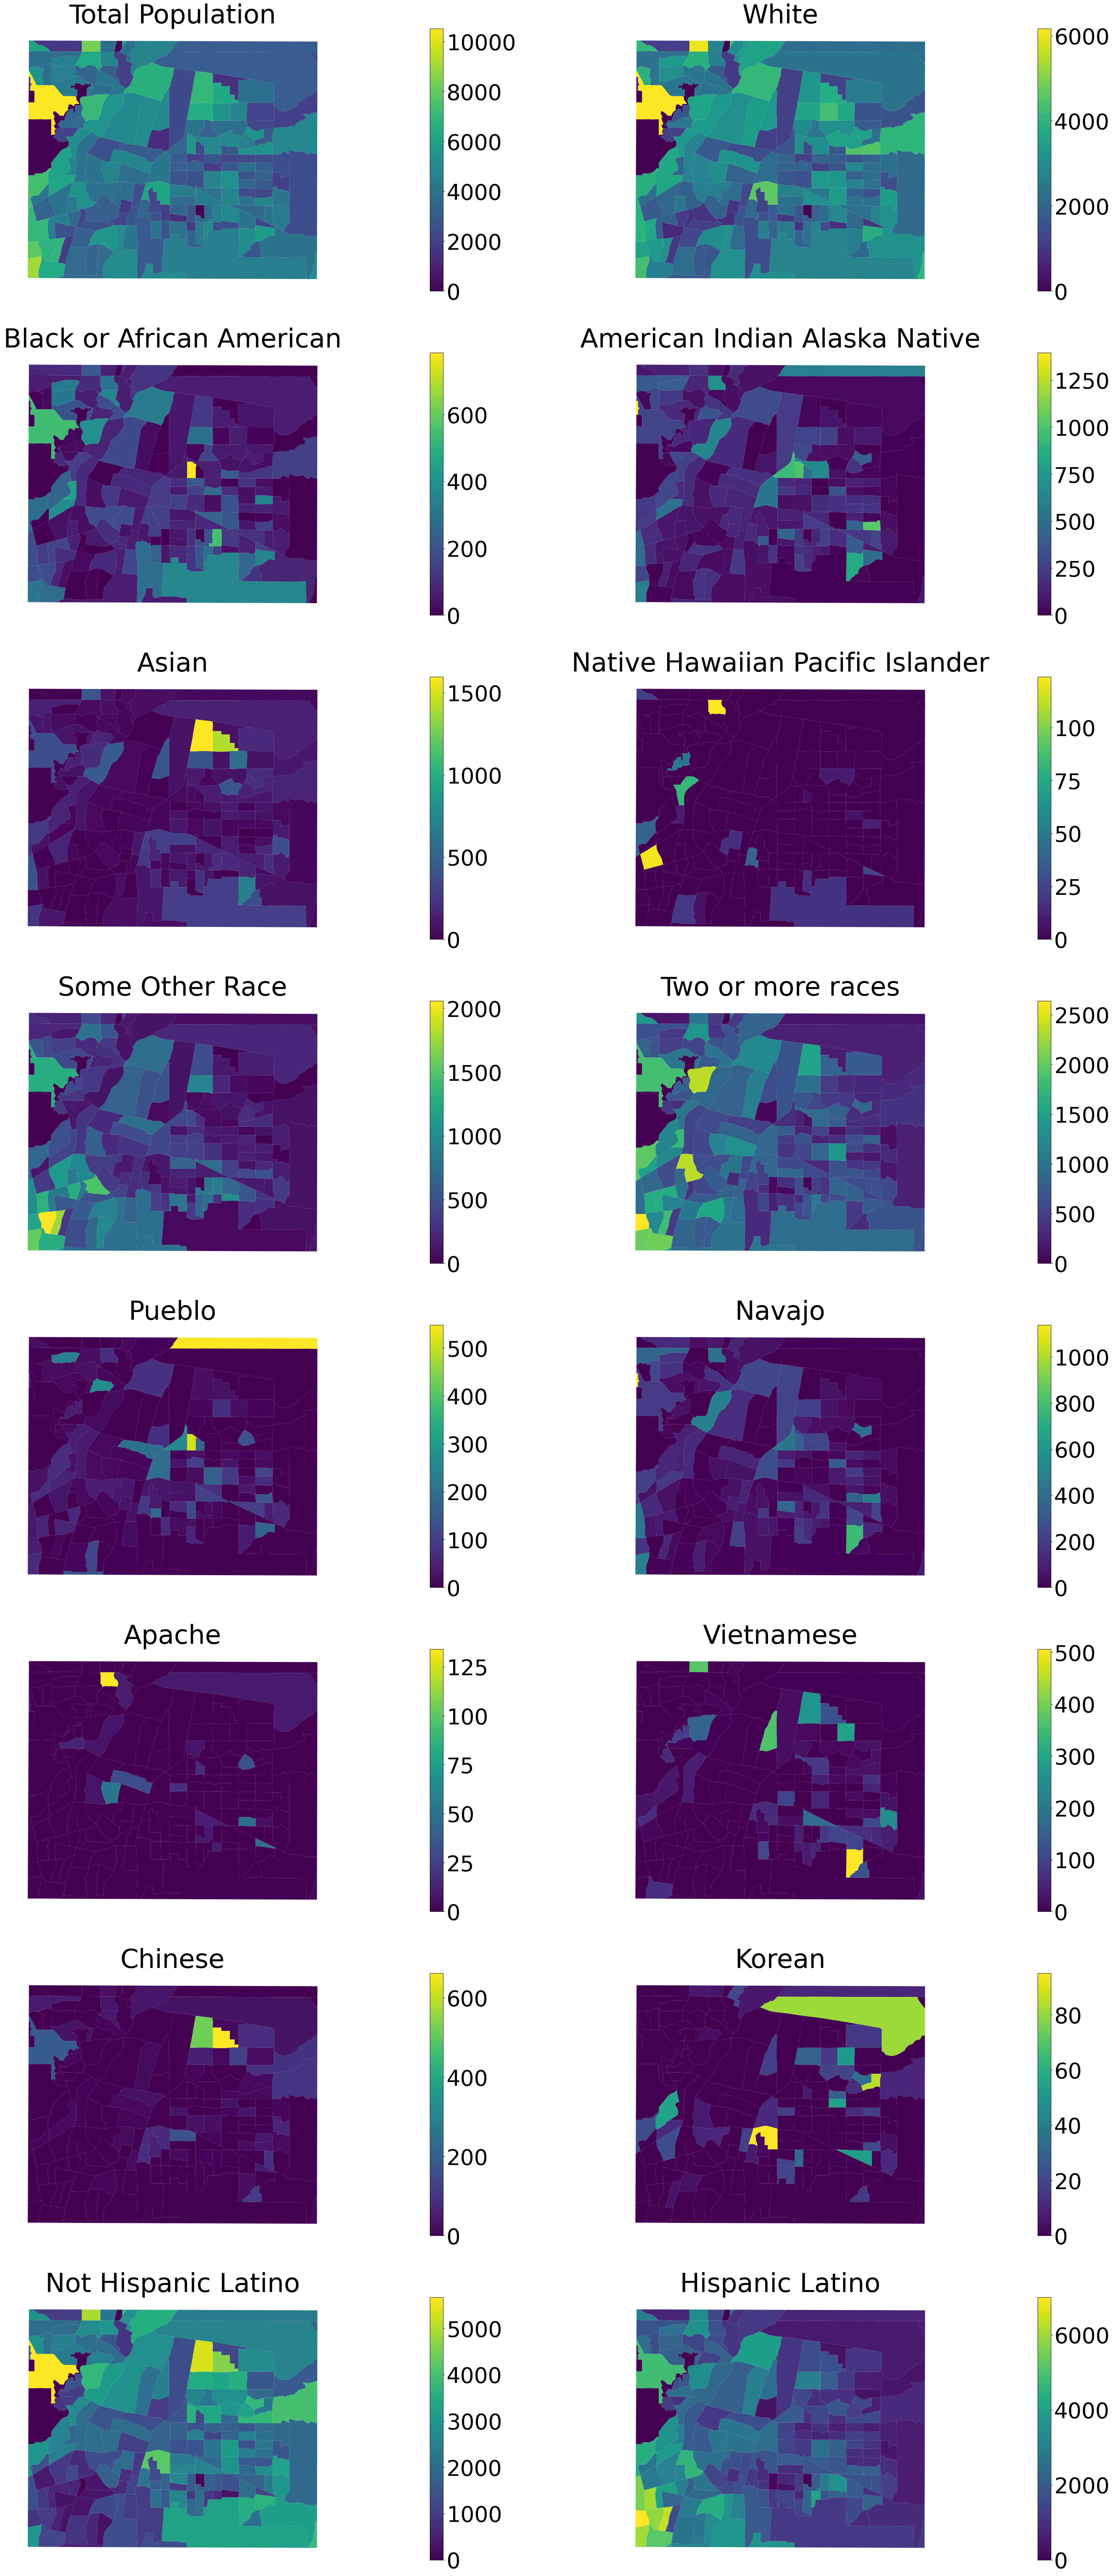

In [19]:
abq_2022 = gpd.read_file('../../../localData/Census/nm_race_sex_2022.gpkg',
                        layer='Albuquerque')
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(75,75), layout='tight')

axes = axes.flatten()

# Setting the font size
plt.rcParams['font.size'] = '45'
plt.style.use('seaborn-v0_8-dark-palette')

# Plotting each of the extracted variables in a subplot
for ind, col in enumerate(list(fields.values())[1:]):
    ax = axes[ind]
    abq_2022.plot(column=col,
                  ax = ax
                  #, scheme = "quantiles"
                  , linewidth=0, cmap="viridis", 
                    legend=True
                  #, legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5),'fmt': "{:.0f}"}
                 ) 
    ax.set_axis_off()
    ax.set_title(col)
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

## Get Country-wide data

In [20]:
us_demo_2022_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2022
    )
us_demo_2019_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2019
    )
us_demo_2016_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2016
    )

In [21]:
us_demo_2022_df = pd.DataFrame(us_demo_2022_dl)
us_demo_2019_df = pd.DataFrame(us_demo_2019_dl)
us_demo_2016_df = pd.DataFrame(us_demo_2016_dl)

In [22]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

In [23]:
us_tract_2022 = gpd.read_file('../../../data/local/tl_2022_us_county.zip')[['GEOID', 'geometry']]
us_tract_2019 = gpd.read_file('../../../data/local/tl_2019_us_county.zip')[['GEOID', 'geometry']]
us_tract_2016 = gpd.read_file('../../../data/local/tl_2016_us_county.zip')[['GEOID', 'geometry']]

In [24]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df['GEOID'] = (df.state + df.county)

In [25]:
us_demo_2022 = us_tract_2022.merge(us_demo_2022_df, on='GEOID')
us_demo_2019 = us_tract_2019.merge(us_demo_2019_df, on='GEOID')
us_demo_2016 = us_tract_2016.merge(us_demo_2016_df, on='GEOID')

In [26]:
us_demo_2022.to_file('../../../data/Census/us_race_sex_2022.gpkg')
us_demo_2019.to_file('../../../data/Census/us_race_sex_2019.gpkg')
us_demo_2016.to_file('../../../data/Census/us_race_sex_2016.gpkg')